In [31]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
dataset = pd.read_csv('data/sample_data/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Feature Engineering

In [33]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [34]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [35]:
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

In [36]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)
print(dataset.columns)
dataset.iloc[:, 5:20].head(100)
dataset.head()

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,is_repeated_guest,previous_cancellations,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned
0,Resort Hotel,False,342,July,27,BB,PRT,Direct,0,0,...,3,No Deposit,0,Transient,0.0,0,0,0,2.0,False
1,Resort Hotel,False,737,July,27,BB,PRT,Direct,0,0,...,4,No Deposit,0,Transient,0.0,0,0,0,2.0,False
2,Resort Hotel,False,7,July,27,BB,GBR,Direct,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,True
3,Resort Hotel,False,13,July,27,BB,GBR,Corporate,0,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,False
4,Resort Hotel,False,14,July,27,BB,GBR,Online TA,0,0,...,0,No Deposit,0,Transient,98.0,0,1,2,2.0,False


In [37]:
dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  arrival_date_month  \
deposit_type is_canceled                                         
No Deposit   False        74947      74947               74947   
             True         29690      29690               29690   

                          arrival_date_week_number   meal  country  \
deposit_type is_canceled                                             
No Deposit   False                           74947  74947    74947   
             True                            29690  29690    29690   

                          market_segment  is_repeated_guest  \
deposit_type is_canceled                                      
No Deposit   False                 74947              74947   
             True                  29690              29690   

                          previous_cancellations  \
deposit_type is_canceled                           
No Deposit   False                         74947   
             True                          29690   

                          previous_bookings_not_canceled  booking_changes  \
deposit_type is_canceled                                                    
No Deposit   False                                 74947            74947   
             True                                  29690            29690   

                          days_in_waiting_list  customer_type    adr  \
deposit_type is_canceled                                               
No Deposit   False                       74947          74947  74947   
             True                        29690          29690  29690   

                          required_car_parking_spaces  \
deposit_type is_canceled                                
No Deposit   False                              74947   
             True                               29690   

                          total_of_special_requests  total_stay  guests  \
deposit_type is_canceled                                                  
No Deposit   False                            74947       74947   74947   
             True                             29690       29690   29690   

                          different_room_assigned  
deposit_type is_canceled                           
No Deposit   False                          74947  
             True                           29690

In [38]:
dataset_copy = dataset.copy(deep=True)

## Calculate the expected count

In [39]:

# counts_sum=0
# for i in range(1,10000):
#         counts_i = 0
#         rdf = dataset.sample(1000)
#         counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
#         counts_sum+= counts_i
# counts_sum/10000

In [40]:
# Expected Count when there are no booking changes = 49.2%
# counts_sum=0
# for i in range(1,10000):
#         counts_i = 0
#         rdf = dataset[dataset["booking_changes"]==0].sample(1000)
#         counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
#         counts_sum+= counts_i
# counts_sum/10000

In [41]:
# Expected Count when there are booking changes = 66.4%
# counts_sum=0
# for i in range(1,10000):
#         counts_i = 0
#         rdf = dataset[dataset["booking_changes"]>0].sample(1000)
#         counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
#         counts_sum+= counts_i
# counts_sum/10000

## Causal Graph

In [48]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->different_room_assigned; U->is_canceled;U->required_car_parking_spaces;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled; 
hotel -> is_canceled;
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> is_canceled;
country->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
}"""

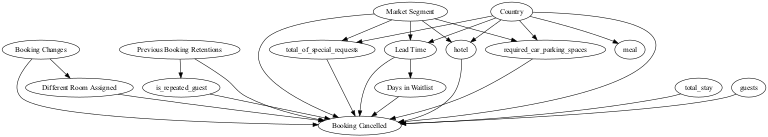

In [50]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Identify the causal effect

In [51]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                       
──────────────────────────(Expectation(is_canceled|booking_changes))
d[different_room_assigned]                                          
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,U) = P(is_canceled|different_room_assigned,booking_changes)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimate the identified estimand

In [52]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                       
──────────────────────────(Expectation(is_canceled|booking_changes))
d[different_room_assigned]                                          
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,U) = P(is_canceled|different_room_assigned,booking_changes)

## Realized estimand
b: is_canceled~different_room_assigned+booking_changes
Target units: ate

## Estimate
Mean value: -0.27378324688268135



## Refute results

Method-1
Radom Common Cause:- Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn't change by much.

In [53]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/causal_inference/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y 

KeyboardInterrupt: 

In [ ]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

In [ ]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)